# 🎯 Aula 8 - Dados atípicos: Outliers 🎯

Na análise de dados, a detecção e correção de outliers são essenciais para garantir a validade das observações. Outliers, que são pontos que se destacam drasticamente do restante dos dados, podem surgir devido à variabilidade natural dos dados ou a erros experimentais e de digitação. 

Tratar adequadamente os outliers é fundamental para garantir análises estatísticas precisas e confiáveis, evitando distorções nos resultados, como médias e modelos de regressão.

# Causas Comuns de Outliers
- **Erros de Medição:** Erros na coleta de dados ou falhas de equipamentos.
- **Erros de Entrada de Dados:** Erros humanos durante a entrada de dados.
- **Variação Natural:** Extrema variação natural nos dados.
- **Mudanças no Comportamento dos Dados:** Mudanças genuínas nas populações ou processos que estão sendo medidos.

# Tipos de Outliers

- **Outliers Pontuais:** São observações individuais que se destacam do resto do conjunto de dados.

- **Outliers Contextuais:** São observações que se destacam no contexto de um subconjunto específico de dados.<br>
Por exemplo, em um estudo sobre o desempenho de estudantes de diferentes escolas, uma pontuação abaixo da média em uma escola de alto desempenho pode ser considerada um outlier contextual.

- **Outliers Coletivos:** São um grupo de observações que, como um todo, se desviam do padrão geral dos dados, mas individualmente podem não ser outliers. <br>
Por exemplo, em um conjunto de dados de vendas mensais, um mês com vendas significativamente mais baixas que os outros meses pode não ser considerado um outlier individualmente, mas quando agrupado com outros meses semelhantes, forma um grupo de outliers coletivos.

# Métodos de Detecção


## Detecção de outliers por meio do desvio-padrão (Z-score)
Uma técnica comum para identificar outliers é usar o desvio-padrão. Um ponto de dados é considerado um outlier se estiver a mais de um certo número de desvios-padrão da média (normalmente 2, compreendendo de 95% dos dados -- veja a imagem abaixo).


## Cálculo do Z-score

Primeiro precisamos normalizar o conjunto de dados. Isso significa representar todos em dados em relação às propriedades da **curva normal** que pode ser escrita em termos de dois parâmetros: média ($\mu$) e desvio-padrão ($\sigma$) -- Estatísticamente escrita como $N(\mu,\sigma)$.

Para normalizar os seus dados $X$ para $N$:

$N = \frac{X - \mu}{\sigma}$

Z-score = $Z = \sigma$

Sendo:
$N$ : dados normalizados
$X$ : dados originais a serem transformados
$\mu, \sigma$ : média e desvio-padrão de $X$, respectivamente

<center><img src="http://www.eajohansson.net/wp-content/uploads/2018/07/standard-normal-distribution-curve.jpg" alt="Curva normal sample" width="400rm"></center>

Observe que, basicamente, o que estamos fazendo é centralizar nossos dados na média $\mu$ e mapear a distribuição de dados somente com o desvio padrão $\sigma$.

**Obs**: Ao realizar esta transformação, estamos assumindo que a distribuição dos dados pode ser descrita por uma curva normal, o que pode ser verdade ou não.

Vamos trazer os dados de corridas de Taxi, usando o Seaborn `load_dataset` e verificar a distribuição de passageiros por corrida (qual é o gráfico que eu ploto a  distribuição mesmo? 🤨)

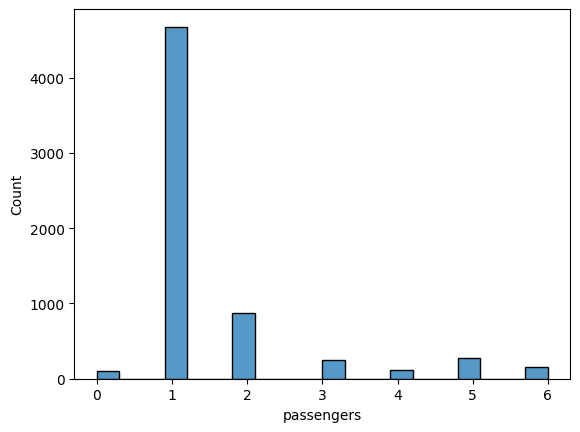

In [15]:
import seaborn as sns
import pandas as pd

# load taxi dataset -- verificar se o alunos tem acesso
df = sns.load_dataset('taxis')

# plot distribution
sns.histplot(df, x='passengers', bins=20);

A qtd de passageiros por corrida parece um pouco com uma curva normal. Se quiséssemos encontrar os outliers desses dados então, poderíamos utilizar o `Z-score`.

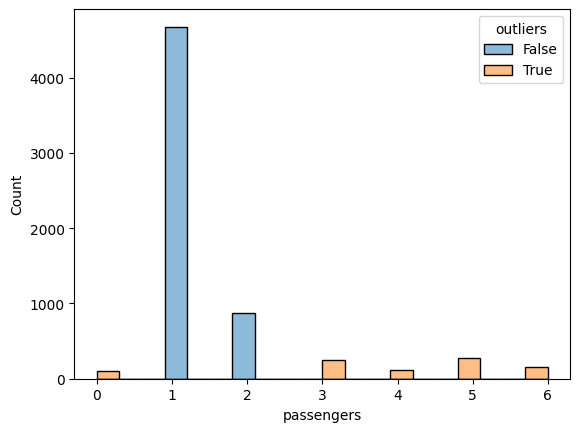

In [16]:
# função para normalizar dados
def normalizar_dados(X):
    # calcular média e desvio-padrão
    mu, sigma = X.mean(), X.std()
    N = (X-mu)/sigma
    return N, mu, sigma

passageiros = df['passengers']
N, media, Z = normalizar_dados(passageiros)

# vamos aplicar uma simples comparação 
# se os dados estão fora do limite 2 Z
df['outliers'] = (N<-Z*2) | (N>Z*2)

sns.histplot(df, x='passengers', bins=20, hue='outliers');

Podemos observar duas coisas:

1. Não é comum ter corridas com 5 ou mais passageiros.

2. É mais comum que as corridas tenham 1 ou 2 pessoas.

## Detecção de outliers pelo IQR (Intervalo Interquartil)

O IQR é a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1). Outliers são definidos como observações que estão abaixo de Q1 - 1.5 * IQR ou acima de Q3 + 1.5 * IQR.

Tomemos como exemplo um dataset fraudes de cartão de crédito. Fazendo uso da função `.describe()`, podemos ver as estatísticas gerais dos dados contidos no dataset:

In [ ]:
#imports
from sklearn.datasets import fetch_openml
import pandas as pd

#load dataset -- verificar se o alunos tem acesso
creditcard = fetch_openml('creditcard',version=1)

# get the whole data
df = pd.concat(
    [creditcard['data'], 
     creditcard['target']], 
     axis=1)

In [27]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.205498e-16,-2.406306e-15,2.238853e-15,...,6.407202e-16,1.656562e-16,-3.568593e-16,2.610582e-16,4.473066e-15,5.213180e-16,1.683537e-15,-3.659966e-16,-1.223710e-16,88.349619
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


Observe que, na coluna `Amount`, a média de gastos fica em torno de 88.34, muito próximo do 3o quartil (75% dos dados). porém o valor máximo é de 25k. Um pouco estranho não?

Porém qual é um valor que consideramos limite para determinar se é um outlier ou não? Nesta seção utilizaremos a distância interquartis (IQR)

O cálculo para determinar a distância interquartis é:

$IQR = 3^o\space quartil - 1^o\space quartil$

In [28]:
q1, q3 = df['Amount'].quantile(q=[.25,.75])
IQR = q3-q1

Segundo a literatura, um ponto é considerado outlier se:

$outlier = \left \{ \begin{aligned} 
  x < 1o \space quartil - 1.5 * IQR\\
  x > 3o \space quartil + 1.5 * IQR
\end{aligned} \right.
$

o valor $1.5$ é um fator que restringe o limite de detecção de outliers.

In [29]:
mask_outlier = (df['Amount'] < q1 - 1.5*IQR) | (df['Amount'] > q3 + 1.5*IQR)
df['outlier'] = mask_outlier

<Axes: ylabel='Amount'>

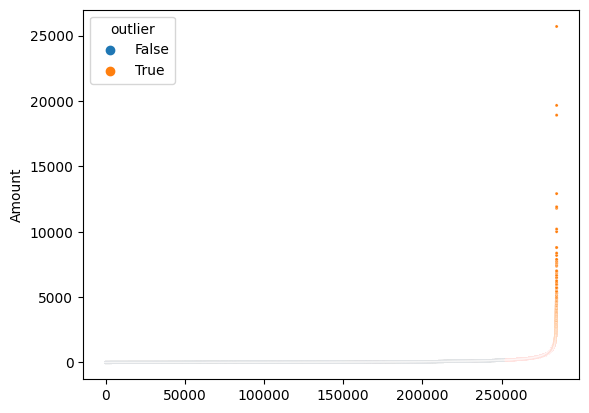

In [33]:
sns.scatterplot(data=df.sort_values('Amount'), x=range(df.shape[0]), y='Amount',hue='outlier', s=5)

Podemos observar que os gastos acima de 180 foram classificados como outliers. 

**Obs**: Ser outlier NÃO garante que foi uma transação fraudulenta. É somente uma classificação estatística, e cabe a ti verificar se essa classificação é relevante ou não.

Tudo isso que acabamos de ver é facilmente projetado num tipo de gráfico chamado `boxplot`,

no qual as linhas mais distantes são os limites inferior e superior
as linhas da caixa são o 1o e o 3o quartil
e a linha do meio é a mediana

In [ ]:
# plotar boxplot
df.query('Amount < 200')['Amount'].plot(kind='box')

# Remoção e tratamento de outliers

A identificação e tratamento de outliers é crucial na análise de dados. 

A remoção de outliers pode ser adequada quando os dados são claramente errôneos ou quando podem distorcer os resultados. No entanto, é importante considerar que a remoção total dos outliers pode levar à perda de informações importantes e introduzir viés na análise.

Em vez disso, a substituição dos outliers pela média, mediana ou moda dos dados pode ser uma técnica útil, especialmente quando a integridade do tamanho da amostra é importante. 

No entanto, essa abordagem também pode distorcer a distribuição dos dados, especialmente se houver muitos outliers presentes.

# Hands-on

1. Realize uma análise de outliers nos dados de empréstimos pessoais. Busque em cada campo dos dados se há presença de outliers, no geral.

2. Em seguida, lembre-se que os outliers podem ser detectados em contextos diferentes. Ou seja, procure agora os outliers separando os dados em categorias diferentes, em relação a coluna alvo (_target_)


# Referências

[Documentação Pandas](https://pandas.pydata.org/docs/)

<!-- Revisor, alguma sugestão de referência sobre critérios para detecção de outliers? --!>